In [19]:
%matplotlib notebook
#Ziyan Zhu
import numpy as np 
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import nntools as nt
import time
from VOCdataset import VOCDataset

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.1.0


In [21]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [22]:
labels = ['background',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'aeroplane']
color = {}
for i in range(len(labels)):    
    color[labels[i]] = np.random.random(3)
    
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    if type(boxes['boxes']) == 'torch.Tensor':
        boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
        boxes['labels'] = boxes['labels'].to('cpu').numpy()

    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],linewidth=1.5,facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 

    if len(scores) == 0:
        ax.axis('off')
        return h
    elif boxes.shape[0] > 0:
        for i in range(len(names)):
            ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],linewidth = 1.5, facecolor='none'))
            ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
        ax.axis('off')
    else:
        ax.gca().add_patch( patches.Rectangle((boxes[0],boxes[1]),boxes[2]- boxes[0],boxes[3]-boxes[1],edgecolor=color[labels[names]],linewidth = 1.5,facecolor='none'))
        ax.annotate(labels[names]+ ':' + str(scores), xy=(boxes[2], boxes[1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names]]))
        ax.axis('off') 
   
    return h

class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [23]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

# Load the model

In [24]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
backbone = tv.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of output channels in a backbone. For vgg16, it's 512
backbone.out_channels = 1280
# let's make the RPN generate 5 x 3 anchors per spatial location, 
# with 5 different sizes and 3 different aspect ratios. 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# let's define what are the feature maps that we will use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
roi_pooler = tv.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
# put the pieces together inside a FasterRCNN model
model_mobnet = FasterRCNN(backbone,num_classes=21,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [25]:
# ignore the pretrained part first
for param in model_mobnet.backbone.parameters():
    param.requires_grad = False
# create experience
lr = 1e-3
model_mobnet = model_mobnet.to(device)
params = [p for p in model_mobnet.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model_mobnet, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_mobnet_0", perform_validation_during_training=True)
new_model = exp1.net
for param in new_model.backbone.parameters():
    param.requires_grad = True
# create experience
lr = 5e-4
new_model = new_model.to(device)
params = [p for p in new_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(new_model, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_mobnet", perform_validation_during_training=True)

# Testing the model

time used:  0.14577245712280273 s
[{'boxes': tensor([[196.9372,   0.0000, 606.6680, 439.5306],
        [241.7075, 191.0472, 601.0983, 383.8945],
        [392.4492,  67.8136, 573.5148, 355.7767],
        [405.2564,  30.7021, 627.0949, 411.7180],
        [194.6441,  40.2487, 608.9969, 216.0536]], device='cuda:0'), 'labels': tensor([19, 19, 14, 19, 19], device='cuda:0'), 'scores': tensor([0.9991, 0.7756, 0.2163, 0.2001, 0.1326], device='cuda:0')}]
---------------------------------
{'boxes': tensor([[208.0000,  21.3333, 606.4000, 390.4000]], device='cuda:0'), 'labels': tensor([19], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[196.9372,   0.0000, 606.6680, 439.5306],
        [392.4492,  67.8136, 573.5148, 355.7767]], device='cuda:0'), 'scores': tensor([0.9991, 0.2163], device='cuda:0'), 'labels': tensor([19, 14], device='cuda:0', dtype=torch.int32)}


<IPython.core.display.Javascript object>


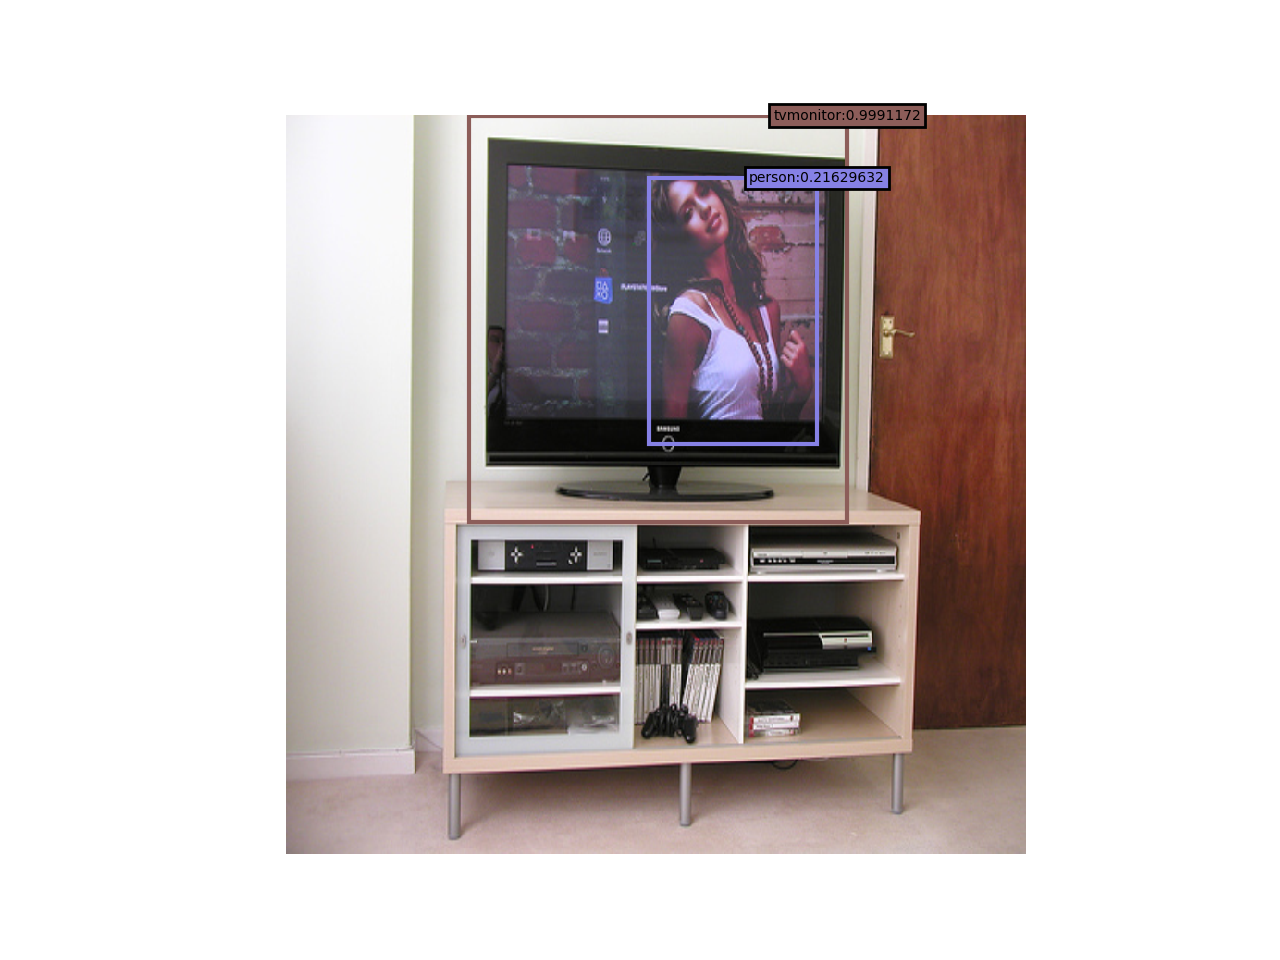

In [32]:
# Output some results (by index of images)
model = exp2.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(1105)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.0)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)

time used:  0.16517400741577148 s
[{'boxes': tensor([[  5.0006, 182.2579, 105.5699, 287.4454],
        [391.1693, 256.7623, 629.1891, 790.1379],
        [148.3098, 221.4341, 496.7907, 800.0000],
        [297.9200, 236.2843, 474.0064, 800.0000],
        [ 33.0470, 198.2227,  93.0557, 299.4571],
        [ 14.4067, 191.9570,  70.9495, 281.0986],
        [102.8275, 227.2841, 755.9625, 800.0000]], device='cuda:0'), 'labels': tensor([ 3, 14, 14, 14,  3,  3, 17], device='cuda:0'), 'scores': tensor([0.9580, 0.9502, 0.9455, 0.7143, 0.3454, 0.3367, 0.0844],
       device='cuda:0')}]
---------------------------------
{'boxes': tensor([[  1.7857, 192.8571, 110.7143, 295.2381],
        [657.1429, 211.9048, 800.0000, 426.1905],
        [ 87.5000, 226.1905, 367.8571, 759.5238],
        [321.4286, 266.6667, 455.3571, 800.0000],
        [410.7143, 283.3333, 621.4286, 800.0000],
        [  1.7857, 285.7143, 800.0000, 800.0000]], device='cuda:0'), 'labels': tensor([ 3,  3, 14, 14, 14,  3], device='cuda:0

<IPython.core.display.Javascript object>


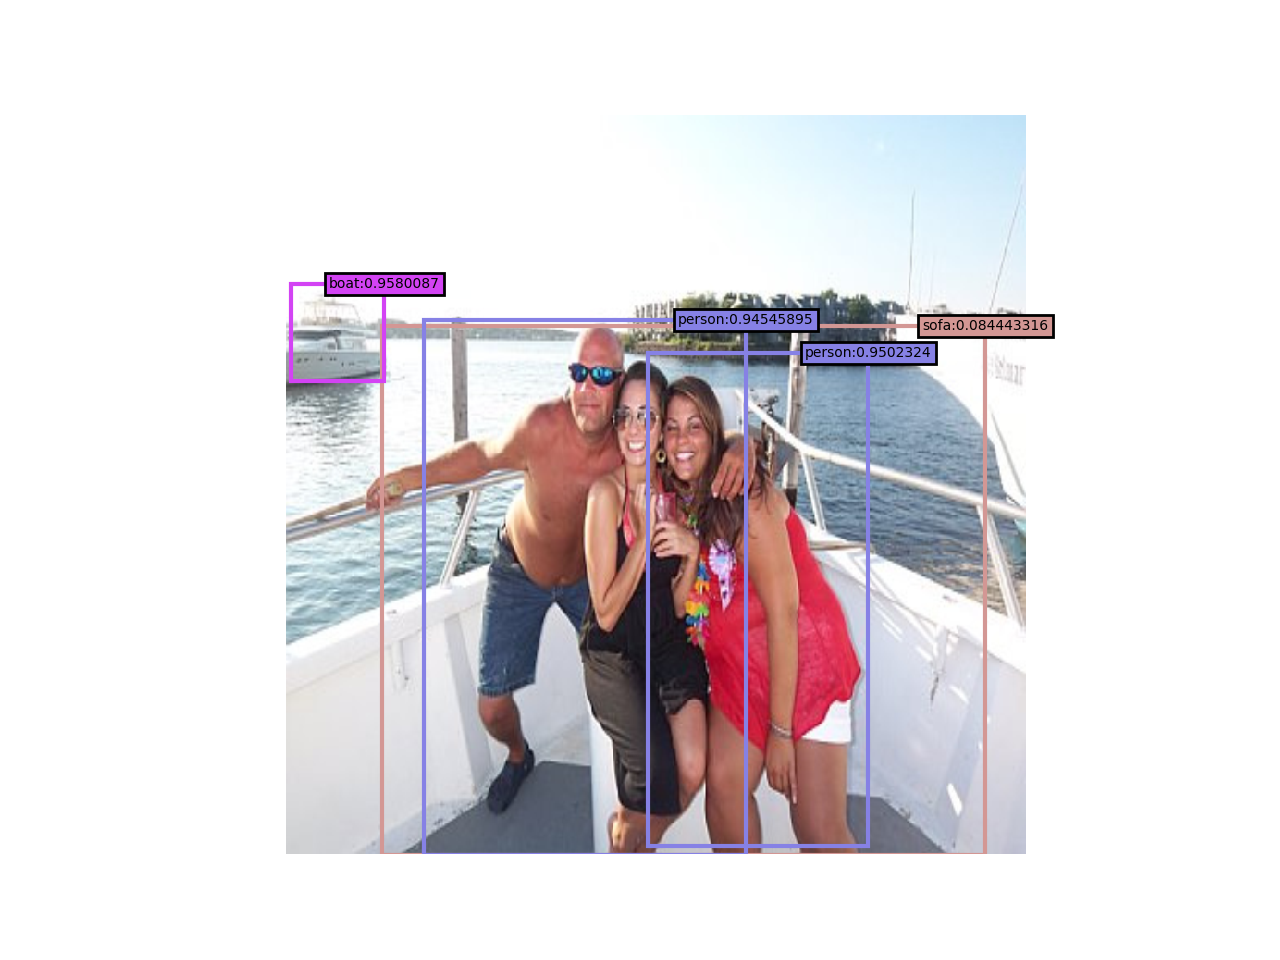

In [30]:
# Output some results (by index of images)
model = exp2.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(2000)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.0)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)

time used:  0.04394221305847168 s
[{'boxes': tensor([[ 42.9223, 109.3511, 700.6619, 722.9413],
        [ 61.1119, 109.5960, 709.7751, 730.2860]], device='cuda:0'), 'labels': tensor([ 3, 20], device='cuda:0'), 'scores': tensor([0.1002, 0.0945], device='cuda:0')}]
---------------------------------
{'boxes': tensor([[ 78.4000,  69.7095, 601.6000, 730.2905]], device='cuda:0'), 'labels': tensor([20], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[ 42.9223, 109.3511, 700.6619, 722.9413],
        [ 61.1119, 109.5960, 709.7751, 730.2860]], device='cuda:0'), 'scores': tensor([0.1002, 0.0945], device='cuda:0'), 'labels': tensor([ 3, 20], device='cuda:0', dtype=torch.int32)}


<IPython.core.display.Javascript object>


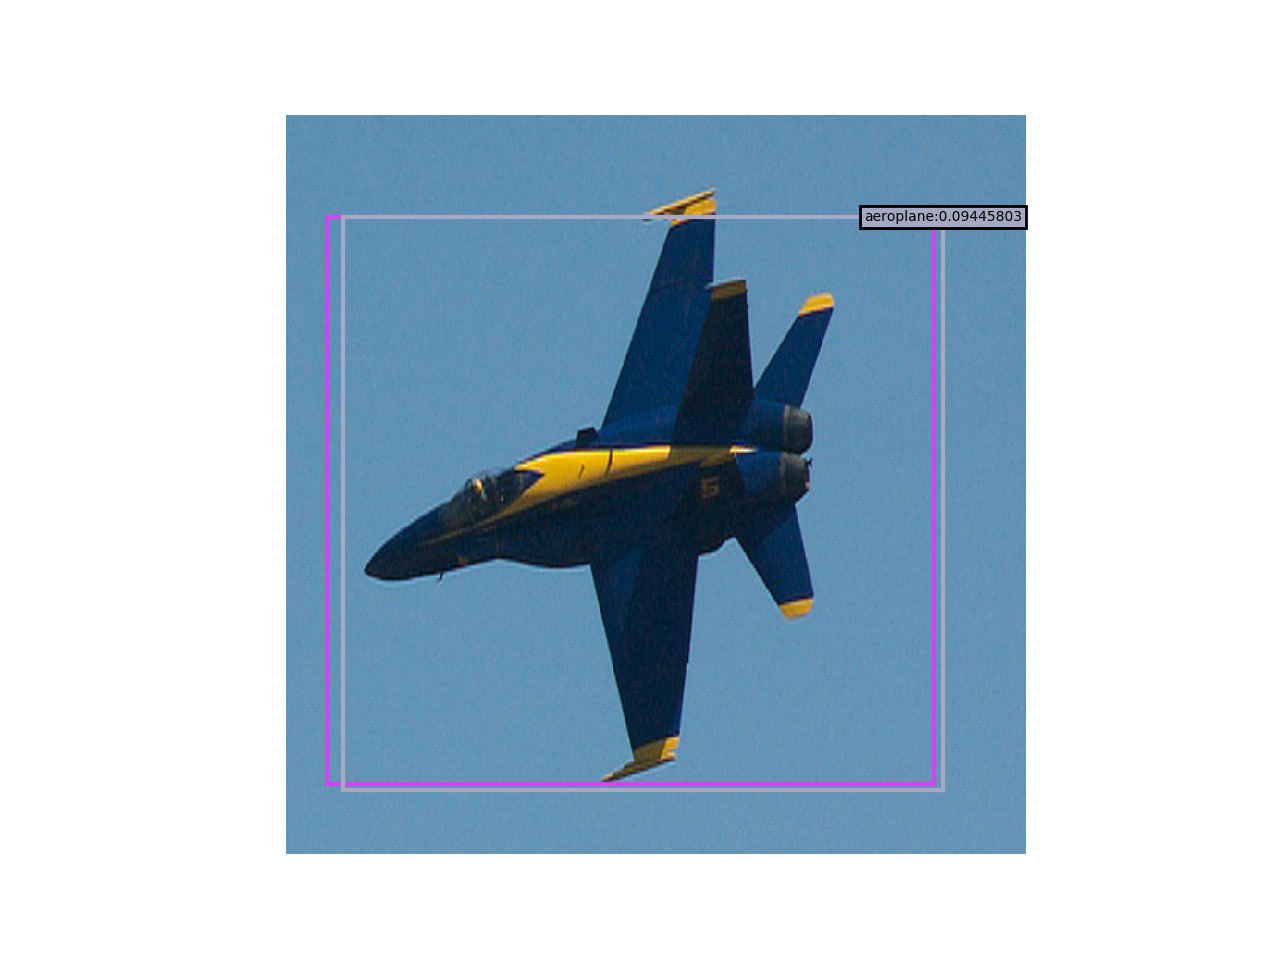

In [28]:
# Output some results (by image name)
model = exp2.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(2000,'2008_001719')
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)